In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report

# Initialize MobileNetV2 for feature extraction
feature_model = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")

def extract_feature(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return feature_model.predict(img_array, verbose=0).flatten()

C:\Users\nohas\AppData\Local\Temp\ipykernel_27880\2930189387.py:13: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  feature_model = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")


In [5]:
def get_data(folder_path, fruit_list=None):
    X, y_s1, y_class = [], [], []
    
    # Identify if folder has fruit/veg subfolders
    subfolders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
    has_category_split = any(cat in subfolders for cat in ["fruit", "vegetable"])

    if has_category_split:
        for cat in ["fruit", "vegetable"]:
            cat_p = os.path.join(folder_path, cat)
            if not os.path.exists(cat_p): continue
            for cls in os.listdir(cat_p):
                cls_p = os.path.join(cat_p, cls)
                if not os.path.isdir(cls_p): continue
                for img in os.listdir(cls_p):
                    X.append(extract_feature(os.path.join(cls_p, img)))
                    y_s1.append(0 if cat == "fruit" else 1)
                    y_class.append(cls)
    else:
        for cls in os.listdir(folder_path):
            cls_p = os.path.join(folder_path, cls)
            if not os.path.isdir(cls_p): continue
            label = 0 if (fruit_list and cls in fruit_list) else 1
            for img in os.listdir(cls_p):
                X.append(extract_feature(os.path.join(cls_p, img)))
                y_s1.append(label)
                y_class.append(cls)
                
    return np.array(X), np.array(y_s1), np.array(y_class)

# --- EXECUTION STEPS ---
# 1. Manually define fruit_set from the TRAIN folder structure
train_fruit_path = os.path.join(base_dir, "train", "fruit")
fruit_set = set(os.listdir(train_fruit_path)) if os.path.exists(train_fruit_path) else set()

# 2. Load all sets using the 3-variable return
X_train, y_train_s1, y_train_class = get_data(os.path.join(base_dir, "train"))
X_val, y_val_s1, y_val_class = get_data(os.path.join(base_dir, "validation"), fruit_set)
X_test, y_test_s1, y_test_class = get_data(os.path.join(base_dir, "test"), fruit_set)

print(f"Loaded {len(X_train)} Train, {len(X_val)} Val, and {len(X_test)} Test images.")

Loaded 3115 Train, 351 Val, and 359 Test images.


In [6]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
s1_models, f_models, v_models = [], [], []

for fold, (t_idx, v_idx) in enumerate(kf.split(X_train)):
    # Stage 1: Balanced Tree
    m1 = DecisionTreeClassifier(random_state=fold, class_weight='balanced')
    m1.fit(X_train[t_idx], y_train_s1[t_idx])
    s1_models.append(m1)

    # Stage 2: Balanced Category Trees
    f_mask = (y_train_s1 == 0) & (np.isin(np.arange(len(y_train_s1)), t_idx))
    v_mask = (y_train_s1 == 1) & (np.isin(np.arange(len(y_train_s1)), t_idx))

    mf = DecisionTreeClassifier(random_state=fold, class_weight='balanced')
    mf.fit(X_train[f_mask], y_train_class[f_mask])
    f_models.append(mf)

    mv = DecisionTreeClassifier(random_state=fold, class_weight='balanced')
    mv.fit(X_train[v_mask], y_train_class[v_mask])
    v_models.append(mv)
    print(f"Fold {fold+1} Trained.")

Fold 1 Trained.
Fold 2 Trained.
Fold 3 Trained.
Fold 4 Trained.
Fold 5 Trained.


In [7]:
def final_evaluate(X, y_s1_true, y_class_true):
    preds_s1, preds_s2 = [], []
    for feat in X:
        feat = feat.reshape(1, -1)
        # Stage 1 Vote
        v1 = [m.predict(feat)[0] for m in s1_models]
        win1 = Counter(v1).most_common(1)[0][0]
        preds_s1.append(win1)
        # Stage 2 Vote
        pool = f_models if win1 == 0 else v_models
        v2 = [m.predict(feat)[0] for m in pool]
        preds_s2.append(Counter(v2).most_common(1)[0][0])

    print("--- Stage 1 Performance ---")
    print(classification_report(y_s1_true, preds_s1, target_names=["Fruit", "Veg"]))
    print("\n--- Stage 2 Performance ---")
    print(classification_report(y_class_true, preds_s2))

final_evaluate(X_test, y_test_s1, y_test_class)

--- Stage 1 Performance ---
              precision    recall  f1-score   support

       Fruit       1.00      0.83      0.91        89
         Veg       0.95      1.00      0.97       270

    accuracy                           0.96       359
   macro avg       0.97      0.92      0.94       359
weighted avg       0.96      0.96      0.96       359


--- Stage 2 Performance ---
               precision    recall  f1-score   support

        apple       1.00      0.70      0.82        10
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       1.00      1.00      1.00        10
      cabbage       1.00      1.00      1.00        10
     capsicum       1.00      1.00      1.00        10
       carrot       1.00      0.90      0.95        10
  cauliflower       1.00      1.00      1.00        10
chilli pepper       1.00      1.00      1.00        10
         corn       0.77      1.00      0.87        10
     cucum

Final Accuracy: 97.21%


<Figure size 1500x1200 with 0 Axes>

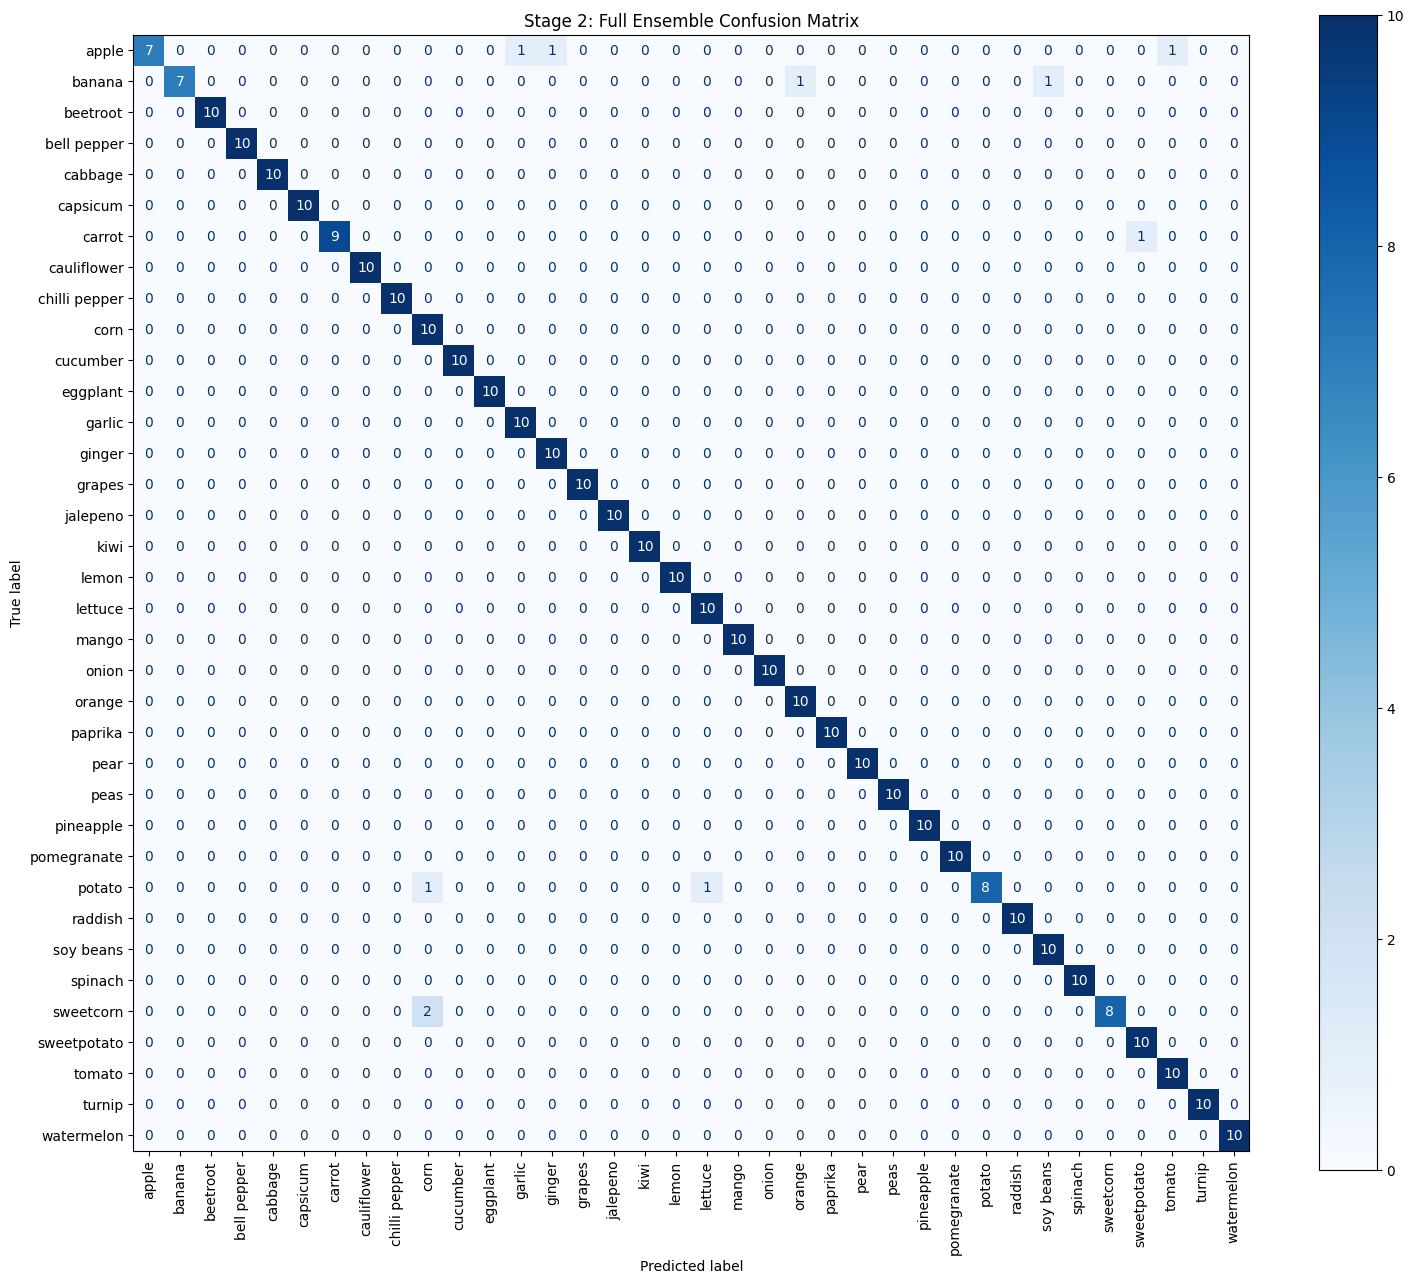

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_advanced_metrics(y_true, y_pred):
    # 1. Compute Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Final Accuracy: {acc * 100:.2f}%")

    # 2. Generate Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # 3. Plotting
    plt.figure(figsize=(15, 12))
    labels = sorted(list(set(y_true)))
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(18, 15))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
    plt.title("Stage 2: Full Ensemble Confusion Matrix")
    plt.show()

def get_test_predictions(X):
    preds_s2 = []
    for feat in X:
        feat = feat.reshape(1, -1)
        v1 = [m.predict(feat)[0] for m in s1_models]
        win1 = Counter(v1).most_common(1)[0][0]
        pool = f_models if win1 == 0 else v_models
        v2 = [m.predict(feat)[0] for m in pool]
        preds_s2.append(Counter(v2).most_common(1)[0][0])
    return preds_s2

test_preds = get_test_predictions(X_test)
plot_advanced_metrics(y_test_class, test_preds)

In [8]:
def predict_new_image(img_path, stage1_models, fruit_models, veg_models):
    feature = extract_feature(img_path).reshape(1, -1)
    
    # 2. Stage 1 Ensemble Vote
    s1_votes = [m.predict(feature)[0] for m in stage1_models]
    # 0 = Fruit, 1 = Vegetable
    final_s1 = max(set(s1_votes), key=s1_votes.count)
    s1_conf = (s1_votes.count(final_s1) / len(s1_votes)) * 100
    
    category_name = "Fruit" if final_s1 == 0 else "Vegetable"
    
    # 3. Stage 2 Ensemble Vote
    target_models = fruit_models if final_s1 == 0 else veg_models
    s2_votes = [m.predict(feature)[0] for m in target_models]
    final_s2 = max(set(s2_votes), key=s2_votes.count)
    s2_conf = (s2_votes.count(final_s2) / len(s2_votes)) * 100
    
    # 4. Display Results
    plt.imshow(load_img(img_path))
    plt.axis('off')
    plt.title(f"Prediction: {final_s2}\nCategory: {category_name} ({s1_conf:.0f}% cert.)\nType Confidence: {s2_conf:.0f}%")
    plt.show()

    return final_s2, s2_conf

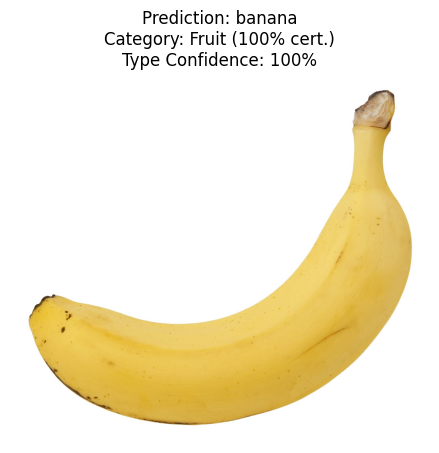

The model identified this as a: banana with 100.0% confidence.


In [16]:
# Path to your downloaded image
test_image_path = r"C:\Users\nohas\Downloads\Banana-Single.jpg"
#test_image_path = r"C:\Users\nohas\Downloads\images (1).jpg"
#test_image_path = r"C:\Users\nohas\Downloads\images (2).jpg"
#test_image_path = r"C:\Users\nohas\Downloads\pngtree-ripe-mango-fruit-with-leaf-for-healthy-snack-png-image_15699037.png"
prediction, confidence = predict_new_image(
    test_image_path, 
    s1_models, 
    f_models, 
    v_models
)

print(f"The model identified this as a: {prediction} with {confidence}% confidence.")